# **Proyecto: 🌍✈️ Sistema integrado de gestión y recomendación de viajes**
### **Materia:** Base de Datos 2025
## Alumno: Delfina González

Este trabajo simula la integración de datos diferentes bases de datos para modelar un sistema de gestión y recomendación de viajes. El sistema **almacena** datos de usuarios, destinos, hoteles, actividades, y realiza **recomendaciones** personalizadas a partir de datos distribuidos en **Neo4j, MongoDB y Redis.**

*En el mundo actual, los viajes y el turismo generan grandes cantidades de información sobre usuarios, destinos, alojamientos y actividades. Las empresas turísticas necesitan sistemas que no solo registren esta información, sino que también permitan realizar análisis, recomendaciones personalizadas y gestionar reservas de manera eficiente.*

Funcionalidades:
 - Almacenar información de usuarios,  historial de reservas, destinos turísticos, hoteles, actividades disponibles y precios asociados. 
 - Gestionar datos temporales como búsquedas recientes o reservas en proceso. 
 - Relaciones de conocimiento entre usuarios, relaciones de usuarios y destinos. 

Estructura del proyecto:

    - PARTE 0: "Configuración y conexiones"
    - PARTE A: "Carga inicial de Datasets"
    - PARTE B: "Consultas"
    - PARTE C: "Estadísticas y Gráficos"
    - PARTE D: "Modificaciones"
    - PARTE F: "Cierre de sesiones"

# PARTE 0: Configuración y conexiones

    Se cargan las bibliotecas
    Se establecen las conexiones con Neo4j, MongoDB y Redis.

In [1112]:
import os, time
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from dotenv import load_dotenv
from neo4j import GraphDatabase
from pymongo import MongoClient
import redis
from datetime import datetime
import numpy as np

# --- Configuración ---
load_dotenv()
print("Esperando servicios (5s)...")
time.sleep(5)

NEO4J_HOST = "bolt://neo4j:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "neo4j123")
MONGO_URI = f"mongodb://{os.getenv('MONGO_INITDB_ROOT_USERNAME', 'admin')}:{os.getenv('MONGO_INITDB_ROOT_PASSWORD', 'admin123')}@mongo:27017/"
REDIS_HOST = "redis"
REDIS_PORT = 6379
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "redis123")

print("Variables cargadas y hosts definidos.")

# --- Conexiones ---
def connect_neo4j():
    try:
        driver = GraphDatabase.driver(NEO4J_HOST, auth=(NEO4J_USER, NEO4J_PASSWORD))
        with driver.session() as s:
            s.run("RETURN 1")
        print("✅ Conectado a Neo4j")
        return driver
    except Exception as e:
        print(f"❌ Error al conectar a Neo4j: {e}")
        return None

def connect_mongo():
    try:
        client = MongoClient(MONGO_URI)
        client.server_info()
        print("✅ Conectado a MongoDB")
        return client
    except Exception as e:
        print(f"❌ Error al conectar a MongoDB: {e}")
        return None

def connect_redis():
    try:
        r = redis.Redis(host=REDIS_HOST, port=REDIS_PORT, password=REDIS_PASSWORD, decode_responses=True)
        r.ping()
        print("✅ Conectado a Redis")
        return r
    except Exception as e:
        print(f"❌ Error al conectar a Redis: {e}")
        return None

neo4j_driver = connect_neo4j()
mongo_client = connect_mongo()
redis_client = connect_redis()

DB_NAME = "base_proyecto"
db = mongo_client[DB_NAME] if mongo_client else None

# Cargo constantes
DESTINO_ID_A_CIUDAD = {
    1: "Bariloche",
    2: "Cancún",
    3: "Madrid",
    4: "Roma",
    5: "Mendoza",
    6: "Ushuaia",
    7: "Puerto Iguazú",
    8: "Salta",
    9: "Río de Janeiro",
    10: "Punta Cana",
    11: "El Calafate",
    12: "Santiago",
    13: "Nueva York",
    14: "Tucumán",
    15: "Mar del Plata",
    16: "San Salvador de Jujuy"
}

CIUDAD_A_DESTINO_ID = {v: k for k, v in DESTINO_ID_A_CIUDAD.items()}

Esperando servicios (5s)...
Variables cargadas y hosts definidos.
✅ Conectado a Neo4j
✅ Conectado a MongoDB
✅ Conectado a Redis


# PARTE A: Carga inicial de Datasets

## 1. Carga de Datos Base y Limpieza
    Se cargan los datos de los archivos JSON requeridos y se limpian las bases de datos.

In [1113]:
DATA_DIR = "data"
required_files = ["usuarios.json", "destinos.json", "hoteles.json", "actividades.json", "reservas.json"]
data = {}
missing = []

for f_name in required_files:
    f_path = os.path.join(DATA_DIR, f_name)
    if os.path.exists(f_path):
        with open(f_path, encoding="utf-8") as f:
            data[f_name.split('.')[0]] = json.load(f)
    else:
        missing.append(f_name)

if missing:
    print(f"⚠️ No se encontraron los siguientes archivos en '{DATA_DIR}/': {', '.join(missing)}")
    print("Por favor, asegúrate de tener todos los archivos JSON necesarios.")
else:
    print("✅ Archivos de datos cargados correctamente.")
    print("-" * 30)

# --- Limpieza de Bases de Datos ---
if neo4j_driver:
    with neo4j_driver.session() as s:
        s.run("MATCH (n) DETACH DELETE n")
        print("✅ Neo4j limpio.")

if mongo_client:
    mongo_client.drop_database(DB_NAME)
    print(f"✅ MongoDB ({DB_NAME}) limpio.")

if redis_client:
    for key in redis_client.scan_iter("tp_*"): 
        redis_client.delete(key)
    print("✅ Claves temporales de Redis limpias.")


✅ Archivos de datos cargados correctamente.
------------------------------
✅ Neo4j limpio.
✅ MongoDB (base_proyecto) limpio.
✅ Claves temporales de Redis limpias.


## 2. Carga en MongoDB, Redis y Neo4j
Se distribuyen los datos:

    - **MongoDB:** Usuarios, Destinos, Hoteles, Actividades y Reservas Concretadas.
    - **Redis:** Reservas Pendientes (temporal) y Usuarios Conectados (set).
    - **Neo4j:** Nodos (Usuarios, Destinos) y Relaciones Sociales y de Visita.

In [1114]:
if data:
    # Carga en MongoDB (Datos permanentes)
    db.usuarios.insert_many(data["usuarios"])
    db.destinos.insert_many(data["destinos"])
    db.hoteles.insert_many(data["hoteles"])
    db.actividades.insert_many(data["actividades"])
    
    # Filtrar Reservas: Concretadas a Mongo
    reservas_concretadas = [
        r for r in data["reservas"] 
        if r["estado"] == "Confirmada"
    ]
    if reservas_concretadas:
        db.reservas.insert_many(reservas_concretadas)
    
    print("✅ Datos base y Reservas concretadas cargados en MongoDB.")

    # Carga en Redis (Datos temporales: Caché y Reservas Pendientes)
    if redis_client:
        redis_client.delete("viajes_usuarios_conectados")
        # Reservas Temporales (Pendientes)
        reservas_pendientes = [
            r for r in data["reservas"] 
            if r["estado"] == "Pendiente"
        ]
        for r in reservas_pendientes:
            clave_pend = f"viajes_reserva:pendiente:{r['reserva_id']}"
            r_str = {k: str(v) for k, v in r.items()}
            redis_client.hset(clave_pend, mapping=r_str)
            redis_client.expire(clave_pend, random.randint(30, 120))
        print(f"✅ {len(reservas_pendientes)} Reservas Pendientes cargadas en Redis.")

        # Usuarios Conectados
        usuarios_conectados = random.sample([usu["nombre"] for usu in data["usuarios"]], k=random.randint(5, 25))
        for nombre in usuarios_conectados:
            redis_client.sadd("viajes_usuarios_conectados", nombre)
        print(f"✅ {len(usuarios_conectados)} Usuarios Conectados cargados en Redis.")

    # Carga en Neo4j (Nodos y Relaciones)
    # Nodos 
    if neo4j_driver:
        with neo4j_driver.session() as s:
            
            s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (u:Usuario) REQUIRE u.usuario_id IS UNIQUE")
            s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Destino) REQUIRE d.destino_id IS UNIQUE")

            # Nodos
            for u in data["usuarios"]:
                s.run("MERGE (u:Usuario {usuario_id:$id, nombre:$nombre})", id=u["usuario_id"], nombre=u["nombre"])
            for d in data["destinos"]:
                s.run("MERGE (d:Destino {destino_id: $id}) SET d.ciudad = $ciudad, d.precio_base = $precio_base", 
                      id=d["destino_id"], ciudad=d["ciudad"], precio_base=d["precio_base"])

    # Relaciones VISITÓ basadas en Reservas Confirmadas Pasadas
    hoy = datetime.now().date()
    reservas_validas = [
        r for r in data.get("reservas", [])
        if r.get("estado") == "Confirmada" and datetime.strptime(r["fecha_reserva"], "%Y-%m-%d").date() <= hoy
        ]
  
    with neo4j_driver.session() as s:
        if reservas_validas not in (None, []):
            for r in reservas_validas:
                u_id = r["usuario_id"]
                d_id = r["destino_id"]
                s.run(
                        """
                        MATCH (u:Usuario {usuario_id:$u}), (d:Destino {destino_id:$d})
                        MERGE (u)-[:VISITO]->(d)
                        """,
                        u=u_id, d=d_id  
                    )
            print(f"✅ {len(reservas_validas)} relaciones VISITÓ creadas en Neo4j basadas en reservas confirmadas pasadas.")
            df_visito = pd.DataFrame(reservas_validas)
            df_visito['Nombre Usuario'] = df_visito['usuario_id'].map({u["usuario_id"]: u["nombre"] for u in data["usuarios"]})
            df_visito['Ciudad Destino'] = df_visito['destino_id'].map(DESTINO_ID_A_CIUDAD)
            display(df_visito[["reserva_id", "fecha_reserva", "estado", "Nombre Usuario", "Ciudad Destino"]].sort_values("Nombre Usuario"))
        else:
            print("⚠️ No hay reservas confirmadas pasadas para crear relaciones VISITÓ.")

        # Relaciones Sociales (AMIGO_DE, FAMILIAR_DE) - Evitando duplicados e inversas
        tipos_relacion = ["AMIGO_DE", "FAMILIAR_DE"] 
            
        # Intentamos crear el triple de relaciones que usuarios
        relaciones_creadas = []

        for _ in range(len(data["usuarios"]) * 3):
                u1 = random.choice(data["usuarios"])
                u2 = random.choice(data["usuarios"])
                u1_id = u1["usuario_id"]
                u2_id = u2["usuario_id"]
                tipo = random.choice(tipos_relacion)

                # 1. Aseguramos que los IDs sean diferentes.
                if u1_id == u2_id:
                    continue
               
                query = f"""
                MATCH (u1:Usuario {{usuario_id: $u1_id}})
                MATCH (u2:Usuario {{usuario_id: $u2_id}})

                WHERE NOT (u1)-[:AMIGO_DE|FAMILIAR_DE]-(u2)
                
                MERGE (u1)-[:{tipo}]->(u2)
                """
                # Ejecutar la query con los parámetros
                resultado_relaciones = s.run(query, u1_id=u1_id, u2_id=u2_id)

                if resultado_relaciones is not None:
                # Almacenar los datos de la relación *creada*
                    relaciones_creadas.append({
                        "Usuario 1": u1["nombre"],
                        "Usuario 2": u2["nombre"],
                        "Tipo de Relación": tipo
                    })
        # Asegurar bidireccionalidad para AMIGO_DE
        query_fix_bidireccional = """
            MATCH (a:Usuario)-[:AMIGO_DE]->(b:Usuario)
            WHERE NOT (b)-[:AMIGO_DE]->(a)
            MERGE (b)-[:AMIGO_DE]->(a)
            RETURN COUNT(*) AS relaciones_creadas
            """

        try:
            result = s.run(query_fix_bidireccional).single()
            cantidad_creadas = result["relaciones_creadas"] if result else 0
            print(f"🔄 Se aseguraron {cantidad_creadas} relaciones AMIGO_DE bidireccionales.")
        except Exception as e:
            print("⚠️ Error al asegurar bidireccionalidad:", e)

        df_relaciones = pd.DataFrame(relaciones_creadas)

        print(f"✅ {df_relaciones.shape[0]} Relaciones sociales (AMIGO_DE/FAMILIAR_DE) creadas.")

        pd.set_option('display.max_rows', 100)
        pd.set_option('display.max_colwidth', 500)

        display(df_relaciones.sort_values(["Tipo de Relación", "Usuario 1"]).reset_index(drop=True))

✅ Datos base y Reservas concretadas cargados en MongoDB.
✅ 13 Reservas Pendientes cargadas en Redis.
✅ 19 Usuarios Conectados cargados en Redis.
✅ 29 relaciones VISITÓ creadas en Neo4j basadas en reservas confirmadas pasadas.


,reserva_id,fecha_reserva,estado,Nombre Usuario,Ciudad Destino
28,50,2025-04-20,Confirmada,Agustina Benítez,Río de Janeiro
15,25,2025-03-01,Confirmada,Agustina Benítez,Tucumán
2,5,2024-06-25,Confirmada,Ana Torres,Mendoza
12,18,2024-08-25,Confirmada,Andrés Pereyra,Puerto Iguazú
26,47,2025-01-25,Confirmada,Bárbara Nuñez,Ushuaia
24,41,2025-07-15,Confirmada,Carla Gómez,Bariloche
18,31,2025-09-10,Confirmada,Delfina Giménez,Mendoza
11,17,2024-07-20,Confirmada,Diego Romero,Ushuaia
8,11,2024-01-01,Confirmada,Emilia Ríos,Bariloche
19,32,2025-10-15,Confirmada,Ezequiel Blanco,Ushuaia


🔄 Se aseguraron 73 relaciones AMIGO_DE bidireccionales.
✅ 147 Relaciones sociales (AMIGO_DE/FAMILIAR_DE) creadas.


,Usuario 1,Usuario 2,Tipo de Relación
0,Agustina Benítez,Juan López,AMIGO_DE
1,Agustina Benítez,Catalina Ponce,AMIGO_DE
2,Agustina Benítez,Lucia Sala,AMIGO_DE
3,Ana Torres,Irene Montes,AMIGO_DE
4,Ana Torres,Carla Gómez,AMIGO_DE
...,...,...,...
142,Sofia Olmos,Javier Rivas,FAMILIAR_DE
143,Sofía Morales,Ramiro Chávez,FAMILIAR_DE
144,Sofía Morales,Carla Gómez,FAMILIAR_DE
145,Valentina Gil,Máximo Álvarez,FAMILIAR_DE


# PARTE B: Consultas

## 1. Funciones de Consulta (a–l)
Definición de las funciones *helper* y las consultas específicas para cada base de datos.

In [ ]:
# --- FUNCIONES DE AUXILIARES PARA LAS CONSULTAS -----------------------------------------------
def query_neo4j(query, params=None):
    """Ejecuta una consulta en Neo4j y devuelve lista de diccionarios."""
    if not neo4j_driver:
        return []

    with neo4j_driver.session() as s:
        try:
            result = s.run(query, **(params or {}))
            # Convertir cada registro en dict (para Pandas)
            return [dict(r) for r in result]
        except Exception as e:
            print("⚠️ Error en query_neo4j:", e)
            return []

def query_mongo(collection_name, query):
    """Función helper para ejecutar consultas en MongoDB."""
    
    if db is None: 
        return []
        
    return list(db[collection_name].find(query))

def query_redis(pattern):
    """
    Función helper para ejecutar consultas en Redis.
    DECODIFICA CONDICIONALMENTE TANTO CLAVES COMO VALORES de los Hash.
    """
    if redis_client is None: 
        return []

    keys = redis_client.keys(pattern)
    results = []
    
    for key in keys:
        byte_data = redis_client.hgetall(key)
        decoded_data = {}
        
        for k, v in byte_data.items():
            decoded_key = k.decode('utf-8') if isinstance(k, bytes) else k
            decoded_value = v.decode('utf-8') if isinstance(v, bytes) else v
            decoded_data[decoded_key] = decoded_value
        results.append(decoded_data)
            
    return results

# --- PUNTO A -------------------------------------------------------------------------------

def consulta_a_usuarios_bariloche():
    """Consulta 2.a: Mostrar los usuarios que visitaron 'Bariloche'."""
    q = "MATCH (u:Usuario)-[:VISITO]->(d:Destino {ciudad:'Bariloche'}) RETURN u.nombre AS nombre, u.usuario_id AS id"
    pd_a = pd.DataFrame(query_neo4j(q)).rename(columns={0: "Usuario", 1: "ID Usuario"})
    return pd_a

# --- PUNTO B -------------------------------------------------------------------------------

def consulta_b_amigos_destinos(nombre):
    """Consulta 2.b: Amigos de Juan López que visitaron un destino que él también visitó."""
    q = f"""
    MATCH (u:Usuario)-[:AMIGO_DE]->(a:Usuario {{nombre:'{nombre}'}})-[:VISITO]->(d:Destino)
    WHERE (u)-[:VISITO]->(d)
    RETURN 
        u.nombre AS `Amigo`,
        d.ciudad AS `Destino Común`
    ORDER BY `Amigo` ASC, `Destino Común` ASC
    LIMIT 5
    """

    try:
        resultados = query_neo4j(q)
        df_b = pd.DataFrame(resultados)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if df_b.empty:
        print(f"⚠️ No se encontraron amigos que hayan visitado destinos comunes con {nombre}.")
    else:
        print(f"✅ Amigos de {nombre} que visitaron destinos comunes:")
        
    return df_b

# --- PUNTO C -------------------------------------------------------------------------------

def consulta_c_sugerir_destinos(nombre, preferencia_de_búsqueda):
    """
    Consulta 2.c: Sugerir destinos que no haya visitado el usuario ni sus amigos.
    Permite ordenar por popularidad o precio (menor o mayor).
    """

    preferencia = preferencia_de_búsqueda.strip().lower() if preferencia_de_búsqueda else "popularidad"
    
    # --- Estructura para la EXCLUSIÓN (común a todas las consultas) ---
    
    exclusion_base = f"""
    MATCH (u:Usuario {{nombre:'{nombre}'}})
    OPTIONAL MATCH (u)-[:VISITO]->(d_user:Destino)
    OPTIONAL MATCH (u)-[:AMIGO_DE]->(p:Usuario)-[:VISITO]->(d_friend:Destino)
    WITH u, collect(DISTINCT d_user) + collect(DISTINCT d_friend) AS no_sugerir_list
    """
    
    if preferencia == "mayor precio":
        q = exclusion_base + """
        MATCH (d:Destino)
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, d.precio_base AS Precio
        ORDER BY Precio DESC, Destino_Sugerido ASC
        LIMIT 3
        """

    elif preferencia == "menor precio":
        q = exclusion_base + """
        MATCH (d:Destino)
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, d.precio_base AS Precio
        ORDER BY Precio ASC, Destino_Sugerido ASC
        LIMIT 3
        """ 

    else:  # Popularidad
        preferencia = "popularidad"
        q = exclusion_base + """
        MATCH (d:Destino)<-[:VISITO]-(otros:Usuario)
        WITH no_sugerir_list, d, count(otros) AS popularidad
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, popularidad AS Valoracion
        ORDER BY popularidad DESC, Destino_Sugerido ASC
        LIMIT 3
        """

    try:
        resultados = query_neo4j(q)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if not resultados:
        print(f"⚠️ No se encontraron destinos sugeridos para {nombre}.")
        return pd.DataFrame()

    df_c = pd.DataFrame(resultados)

    print(f"✅ Destinos sugeridos para {nombre} ordenados por '{preferencia}':")
    
    return df_c

# --- PUNTO D -------------------------------------------------------------------------------

def consulta_d_recomendar_por_amigos(usuario):
    """Consulta 2.d: Recomendar destinos basados en viajes de amigos (no visitados por el usuario)."""
    q = f"""MATCH (u:Usuario {{nombre:'{usuario}'}})-[:AMIGO_DE]->(a:Usuario)-[:VISITO]->(d:Destino)
           WHERE NOT (u)-[:VISITO]->(d)
           RETURN DISTINCT a.nombre AS Referente, d.ciudad AS Destino, d.destino_id AS `Destino ID` LIMIT 5"""
    
    resultado_relaciones = query_neo4j(q)

    if not resultado_relaciones:
        print("⚠️ No se encontraron viajes basados en amigos para recomendar.")
        return None
    else:
        df_d = pd.DataFrame(resultado_relaciones) 

    return df_d

# --- PUNTO E -------------------------------------------------------------------------------

def consulta_e_hoteles_destinos_recomendados(df_recomendaciones):
    """Lista los hoteles en los destinos recomendados basándose en el Destino ID."""
    
    if df_recomendaciones is None or df_recomendaciones.empty:
        print("No hay destinos recomendados.")
        return pd.DataFrame()
        
    ciudades_ids = [int(i) for i in df_recomendaciones['Destino ID'].unique().tolist()]
        
    if not ciudades_ids:
        return pd.DataFrame()

    q = {"destino_id": {"$in": ciudades_ids}}
    hoteles_data = query_mongo("hoteles", q)
    
    if not hoteles_data:
        print(f"No se encontraron hoteles en los IDs: {ciudades_ids}")
        return pd.DataFrame()

    df_e = pd.DataFrame(hoteles_data)
 
    df_e['Ciudad'] = df_e['destino_id'].map(DESTINO_ID_A_CIUDAD)
    
    df_final = df_e[[
        'nombre', 
        'Ciudad', 
        "precio", 
        'servicios'
    ]].sort_values("precio", ascending=True).rename(columns={"nombre": "Hotel"})
    
    print("\n✅ Hoteles en Destinos Recomendados:")
        
    return df_final

# --- PUNTO F -------------------------------------------------------------------------------

def consulta_f_reservas_en_proceso():
    """Consulta 2.f: Ver las reservas en proceso (Redis) usando la función helper."""
    
    reservas = query_redis("viajes_reserva:pendiente:*")

    df_f = pd.DataFrame(reservas)[["reserva_id", "usuario_id", "destino_id", "fecha_reserva", "estado","precio_total"]]
    
    df_f = df_f.sort_values(by=['usuario_id', 'fecha_reserva'], ascending=True)
    
    print(f"\n✅ {df_f.shape[0]} Reservas en Proceso (Obtenidas de Redis):")
    
    return df_f

# --- PUNTO G -------------------------------------------------------------------------------

def consulta_g_usuarios_conectados():
    """Consulta 2.g: Listar los usuarios conectados actualmente (Redis) usando el helper de SET."""
    
    usuarios_conectados = query_redis("viajes_usuarios_conectados")
    
    if not usuarios_conectados:
        print("No se encontraron usuarios conectados actualmente.")
        return pd.DataFrame()
        
    df_g = pd.DataFrame(
        usuarios_conectados, 
        columns=['Usuario Conectado']
    ).sort_values(by='Usuario Conectado')
    
    print(f"\n✅ {df_g.shape[0]} Usuarios Conectados Actualmente:")
        
    return df_g

# --- PUNTO H -------------------------------------------------------------------------------

def consulta_h_destinos_baratos(precio_max=100000):
    """Consulta 2.h: Mostrar los destinos con precio inferior a $100.000 (Mongo)."""
    q = {"precio_base": {"$lt": precio_max}}

    df_h = pd.DataFrame(query_mongo("destinos", q))[['ciudad', 'pais', 'precio_base']]
    df_h = df_h.rename(columns={"precio_base": "Precio","ciudad": "Ciudad","pais": "País"}).sort_values(by='Precio', ascending=True)

    return df_h

# --- PUNTO I -------------------------------------------------------------------------------

def consulta_i_hoteles_destino(ciudad="Jujuy"):
    """Consulta 2.i: Mostrar todos los Hoteles de un destino (Mongo)."""
    ciudad_id = CIUDAD_A_DESTINO_ID.get(ciudad)

    q = {"destino_id": ciudad_id}
    hoteles_ciudad = query_mongo("hoteles", q)

    df_i = pd.DataFrame(hoteles_ciudad).rename(columns={
        'nombre': 'Hotel',
        'ciudad': 'Ciudad',
        'precio': 'Precio',
        'servicios': 'Servicios',
        'calificacion' : 'Calificación'
    })
   
    return df_i

# --- PUNTO J -------------------------------------------------------------------------------

def consulta_j_cantidad_hoteles(ciudad="Bariloche"):
    """Consulta 2.j: Mostrar la cantidad de hoteles de un destino (Mongo)."""
    id_ciudad = CIUDAD_A_DESTINO_ID.get(ciudad)
    rta_j = db.hoteles.count_documents({"destino_id": id_ciudad})
       
    return rta_j

# --- PUNTO K -------------------------------------------------------------------------------

def consulta_k_actividades_por_tipo(ciudad="Ushuaia", tipo="aventura"):
    """Consulta 2.k: Mostrar las actividades de una ciudad y tipo (Mongo)."""
    q = {"ciudad": ciudad, "tipo": tipo}
    df_k = pd.DataFrame(query_mongo("actividades", q))[['nombre', 'ciudad', 'tipo', 'precio']]
    df_k = df_k.rename(columns={
        'nombre': 'Actividad',
        'ciudad': 'Ciudad',
        'tipo': 'Tipo',
        'precio': 'Precio'
    }).sort_values(by='Precio', ascending=True)

    return df_k

# --- PUNTO L -------------------------------------------------------------------------------

def consulta_l_reservas_por_usuario():
    """Consulta 2.l: Muestra la cantidad de reservas concretadas de cada usuario (Mongo)."""

    q = [{'$match': {'estado': 'Confirmada'}}, 
         {'$group': {'_id': '$usuario_id', 'Cantidad de Reservas': {'$sum': 1}}},
         {'$project': {'usuario_id': '$_id', 'Cantidad de Reservas': 1, '_id': 0}},
         {'$sort': {'Cantidad de Reservas': -1}}]

    reservas_df = pd.DataFrame(list(db.reservas.aggregate(q))) 
    
    if reservas_df.empty: return pd.DataFrame()

    usuarios_df = pd.DataFrame(list(db.usuarios.find({}, {"usuario_id": 1, "nombre": 1, "_id": 0})))
    
    df_final = pd.merge(reservas_df, usuarios_df, on='usuario_id', how='left').fillna({"nombre": "Desconocido"}).sort_values(by="Cantidad de Reservas", ascending=False, ignore_index=True)
    print("\n✅ Cantidad de Reservas Concretadas por Usuario:")
    
    return df_final
 
# ---- Funciones auxiliares para mostrar verificaciones -------------------------------------

def obtener_amigos_y_destinos_visitados(nombre_referencia):
    """
    Obtiene los amigos de un usuario y los destinos que visitaron.
    """

    q = f"""
    MATCH (user:Usuario {{nombre: '{nombre_referencia}'}})-[:AMIGO_DE]-(amigo:Usuario)
    OPTIONAL MATCH (amigo)-[:VISITO]->(d:Destino)
    RETURN 
        amigo.nombre AS Amigo,
        collect(DISTINCT coalesce(d.ciudad, "Ninguno")) AS DestinosVisitados
    """

    try:
        resultados = query_neo4j(q)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if not resultados:
        print(f"⚠️ No se encontraron amigos o destinos para {nombre_referencia}.")
        return pd.DataFrame()
    df_amigos = pd.DataFrame(resultados).rename(columns={0: "Amigo/a", 1: "Destinos Visitados"})

        
    return df_amigos 


## 2. Resultados de Consultas Integradas (a–l)



    a) Mostrar los usuarios que visitaron “Bariloche”.

In [1116]:
df_a = consulta_a_usuarios_bariloche()
if df_a is not None:
    display(df_a)

,nombre,id
0,Carla Gómez,3
1,Emilia Ríos,11
2,Juan López,2


    b) Mostrar los amigos de Juan López que visitaron algún destino que visitó él, mostrando el nombre del usuario y el destino.

In [1117]:
# Primero listamos sus amigos y destinos visitados, para poder verificar los resultados.
nombre_usuario = "Juan López"
df_amigos_visitados = obtener_amigos_y_destinos_visitados(nombre_usuario)

if df_amigos_visitados.empty:
    print(f"⚠️ Resultado vacío para '{nombre_usuario}'.")
else:
    print(f"✅ Amigos de {nombre_usuario} y destinos visitados:")
    display(df_amigos_visitados)

✅ Amigos de Juan López y destinos visitados:


,Amigo,DestinosVisitados
0,Agustina Benítez,"[Río de Janeiro, Tucumán]"
1,Julieta Paz,[Ninguno]
2,Nadia Ponce,[Ninguno]


In [1118]:
df_b = consulta_b_amigos_destinos("Juan López")
if df_b is not None:
    display(df_b)

⚠️ No se encontraron amigos que hayan visitado destinos comunes con Juan López.


""


    c) Sugerir destinos a un usuario que no haya visitado él ni sus amigos.

In [1119]:
usuario_para_recomendacion = "Juan López"
preferencia_de_busqueda = input("Indica la preferencia de búsqueda: 'popularidad', 'mayor precio' o 'menor precio'? (default: popularidad): ")
df_c = consulta_c_sugerir_destinos(usuario_para_recomendacion, preferencia_de_busqueda)
if df_c is not None:
    display(df_c)

✅ Destinos sugeridos para Juan López ordenados por 'popularidad':


,Destino_Sugerido,Valoracion
0,Ushuaia,4
1,Punta Cana,3
2,Cancún,2


    d) Recomendar destinos basados en viajes de amigos.

In [1120]:
usuario_para_recomendacion = "Juan López"
df_d = consulta_d_recomendar_por_amigos(usuario_para_recomendacion)
if df_d is not None:
    display(df_d)

,Referente,Destino,Destino ID
0,Agustina Benítez,Río de Janeiro,9
1,Agustina Benítez,Tucumán,14


    e) Listar los hoteles en los destinos recomendados del punto anterior.

In [1121]:
df_e = consulta_e_hoteles_destinos_recomendados(df_d)
if df_e is not None: 
    display(df_e)


✅ Hoteles en Destinos Recomendados:


,Hotel,Ciudad,precio,servicios
2,Estancia Colonial,Tucumán,70000,"[wifi, desayuno]"
3,Hotel Garden Park,Tucumán,95000,"[pileta, restaurante, jardín]"
0,Playa Sol,Río de Janeiro,135000,"[wifi, frente al mar]"
1,Copacabana Palace,Río de Janeiro,280000,"[playa privada, spa, gourmet]"


    f) Ver las reservas en proceso, es decir, aquellas que aún no están concretadas.

In [1122]:
df_f = consulta_f_reservas_en_proceso()
if df_f is not None:    
    display(df_f)


✅ 13 Reservas en Proceso (Obtenidas de Redis):


,reserva_id,usuario_id,destino_id,fecha_reserva,estado,precio_total
2,4,1,4,2026-07-10,Pendiente,100000
3,13,13,12,2026-03-10,Pendiente,95000
8,44,2,4,2026-10-30,Pendiente,110000
12,19,20,8,2026-09-05,Pendiente,70000
5,20,20,9,2026-10-10,Pendiente,130000
1,27,27,1,2026-05-10,Pendiente,90000
0,28,28,2,2026-06-15,Pendiente,150000
9,3,3,3,2026-05-20,Pendiente,110000
6,33,33,7,2026-11-20,Pendiente,75000
11,37,37,11,2026-03-20,Pendiente,135000


    g) Listar los usuarios conectados actualmente.

In [1123]:
df_g = consulta_g_usuarios_conectados()
if df_g is not None:
    display(df_g.head())


✅ 19 Usuarios Conectados Actualmente:


,Usuario Conectado
7,Andrés Pereyra
14,Delfina Giménez
8,Emilia Ríos
3,Gastón Correa
0,Irene Montes


    h) Mostrar los destinos con precio inferior a $100.000.

In [1124]:
df_h = consulta_h_destinos_baratos(100000)
if df_h is not None:
    display(df_h)

,Ciudad,País,Precio
7,San Salvador de Jujuy,Argentina,56000
5,Tucumán,Argentina,65000
3,Salta,Argentina,70000
2,Puerto Iguazú,Argentina,75000
6,Mar del Plata,Argentina,80000
1,Mendoza,Argentina,80000
0,Bariloche,Argentina,90000
4,Santiago,Chile,95000


    i) Mostrar todos los hoteles de “San Salvador de Jujuy”.

In [1125]:
df_i = consulta_i_hoteles_destino("San Salvador de Jujuy")
if df_i is not None:
    display(df_i[['hotel_id', 'Hotel', 'Precio', 'Calificación', 'Servicios']])

,hotel_id,Hotel,Precio,Calificación,Servicios
0,40,Manantial del Silencio,155000,5,"[spa, pileta exterior, restaurante gourmet, vista a cerro de los siete colores]"
1,41,Hotel Altos de La Viña,88000,4,"[wifi, desayuno buffet, estacionamiento]"
2,42,Gran Hotel Jujuy,65000,3,"[wifi, bar, ubicación central]"


    j) Mostrar la cantidad de hoteles de un destino a elección.

In [1126]:
ciudad_favorita = "Bariloche"
rta_j = consulta_j_cantidad_hoteles(ciudad_favorita)

print(f"\n✅ La cantidad de hoteles en {ciudad_favorita} es: {rta_j}")


✅ La cantidad de hoteles en Bariloche es: 3


    k) Mostrar las actividades de “Ushuaia” del tipo “aventura”.

In [1127]:
df_k = consulta_k_actividades_por_tipo("Ushuaia", "aventura")

if df_k is not None:
    display(df_k)

,Actividad,Ciudad,Tipo,Precio
1,Trekking a Laguna Esmeralda,Ushuaia,aventura,35000
0,Navegación Canal Beagle,Ushuaia,aventura,55000
2,Navegación Canal Beagle (Faro Les Éclaireurs),Ushuaia,aventura,55000


    l) Mostrar la cantidad de reservas concretadas de cada usuario (mostrar el nombre del usuario y la cantidad).

In [1128]:
df_l = consulta_l_reservas_por_usuario()
display(df_l)


✅ Cantidad de Reservas Concretadas por Usuario:


,Cantidad de Reservas,usuario_id,nombre
0,2,10,Santiago Castro
1,2,25,Agustina Benítez
2,2,1,María Pérez
3,2,20,Ignacio Vidal
4,2,40,Máximo Álvarez
5,1,39,Lourdes Ferrero
6,1,8,Federico Diaz
7,1,5,Ana Torres
8,1,11,Emilia Ríos
9,1,14,Esteban Aguirre


# PARTE D: Estadística. Gráficos y visualizaciones (m)

    1. Destino más visitado. 
    2. Hotel más barato.   
    3. Actividad más popular.

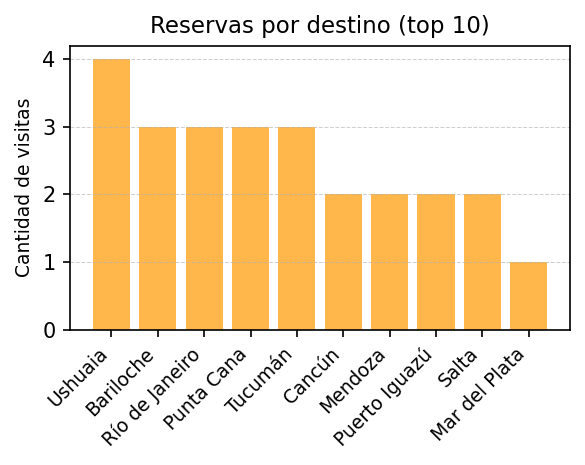

In [1129]:
# ---------- 1) Destino más visitado ----------

# Usamos Neo4j contando relaciones VISITO por destino.

def calcular_destinos_mas_visitados(top_n=10):
    q = """
        MATCH (u:Usuario)-[:VISITO]->(d:Destino)
        RETURN d.destino_id AS destino_id, d.ciudad AS ciudad, count(u) AS cantidad
        ORDER BY cantidad DESC
        """
    with neo4j_driver.session() as s:
        res = s.run(q)
        destinos_agg = [{"_id": r["destino_id"], "cantidad": r["cantidad"], "ciudad": r["ciudad"]} for r in res]

    df = pd.DataFrame([{"destino_id": d["_id"], "ciudad": d.get("ciudad", f"destino_{d['_id']}"), "cantidad": d["cantidad"]} for d in destinos_agg])
    df = df.sort_values("cantidad", ascending=False).head(top_n).reset_index(drop=True)

    return df

df_destinos = calcular_destinos_mas_visitados(top_n=10)

# ---------- 1.A Gráfico: barra (conteo por destino) ----------
if not df_destinos.empty:
    plt.figure(figsize=(4,3.2), dpi=150)
    plt.bar(df_destinos["ciudad"], df_destinos["cantidad"],color='#FFB74C')
    plt.xticks(rotation=45, ha="right", size = 9)
    plt.ylabel("Cantidad de visitas", size = 9)
    plt.title("Reservas por destino (top 10)", size = 11)
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()


✅ El hotel más económico es Altos del Norte. Valor Base = $60,000. Se encuentra en la ciudad de Salta.


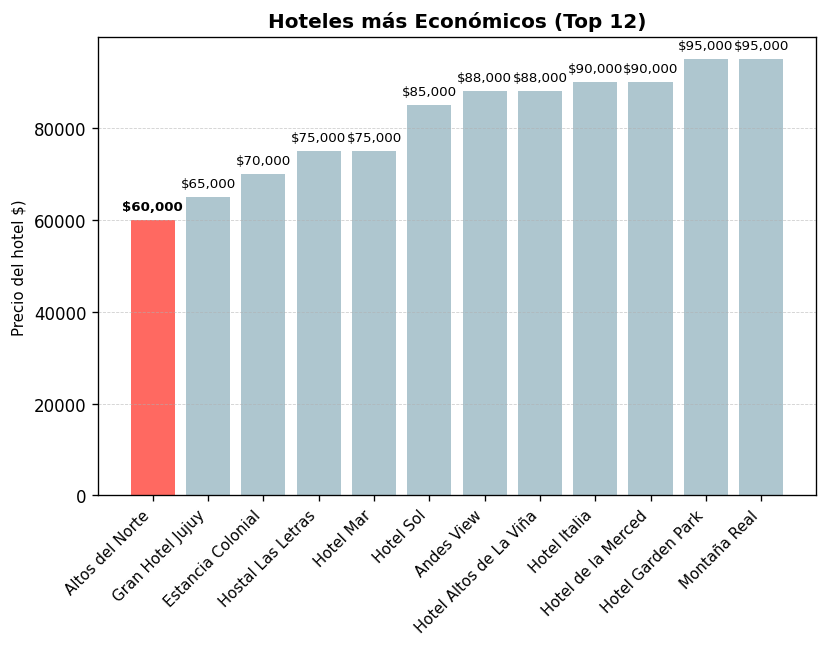

In [1130]:

# ---------- 2) Hotel más barato ----------
# Buscamos el hotel con menor precio en la colección 'hoteles' de MongoDB (si existe)
def obtener_hotel_mas_barato(top_n=10):
    if "hoteles" not in db.list_collection_names():
        return pd.DataFrame()
    cursor = db.hoteles.find({}, {"_id":0, "hotel_id":1, "nombre":1, "destino_id":1, "precio":1}).sort("precio", 1).limit(top_n)
    docs = list(cursor)
    if not docs:
        return pd.DataFrame()
    df = pd.DataFrame(docs)
    return df

df_hoteles_baratos = obtener_hotel_mas_barato(top_n=12)

# ---------- 2.A Gráfico: barras (hoteles, destacar el más barato) - Mejorado ----------
if df_hoteles_baratos.empty:
    print("⚠️ No hay datos de hoteles para graficar.")
else:
    # 1. Localizar el más barato y su ciudad
    idx_min = df_hoteles_baratos["precio"].idxmin()
    min_hotel = df_hoteles_baratos.loc[idx_min, "nombre"]
    min_precio = df_hoteles_baratos.loc[idx_min, "precio"]
    min_id = df_hoteles_baratos.loc[idx_min, "destino_id"]

    ciudad_nombre = DESTINO_ID_A_CIUDAD.get(min_id, "Desconocida") 
    
    print(f"✅ El hotel más económico es {min_hotel}. Valor Base = ${min_precio:,.0f}. Se encuentra en la ciudad de {ciudad_nombre}.")

    plt.figure(figsize=(7, 5.5), dpi=120) 
    
    # 3. Definir colores: Destacar el más barato
    colores = np.array(['#AEC6CF'] * len(df_hoteles_baratos)) # Gris Azulado Pastel por defecto
    colores[idx_min] = '#FF6961' # Rojo Pastel para destacar

    # 4. Crear el gráfico de barras (usando el array de colores)
    bars = plt.bar(df_hoteles_baratos["nombre"], df_hoteles_baratos["precio"], color=colores)
    
    # 5. Etiquetas de precio (Con $ y formato de miles)
    for i, rect in enumerate(bars):
        h = rect.get_height()
        # Muestra el precio con formato de miles ($15,000)
        plt.annotate(f"${int(h):,}", 
                     xy=(rect.get_x() + rect.get_width()/2, h), 
                     xytext=(0,4), 
                     textcoords="offset points", 
                     ha="center", 
                     va="bottom", 
                     fontsize=8, 
                     fontweight='bold' if i == idx_min else 'normal') # Negrita para el más barato
        
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.ylabel("Precio del hotel $)", size=9)
    plt.title(f"Hoteles más Económicos (Top {len(df_hoteles_baratos)})", size=12, fontweight='bold')
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()


✅ La actividad más popular es **Tren del Fin del Mundo**. Cantidad de Reservas = **4**.


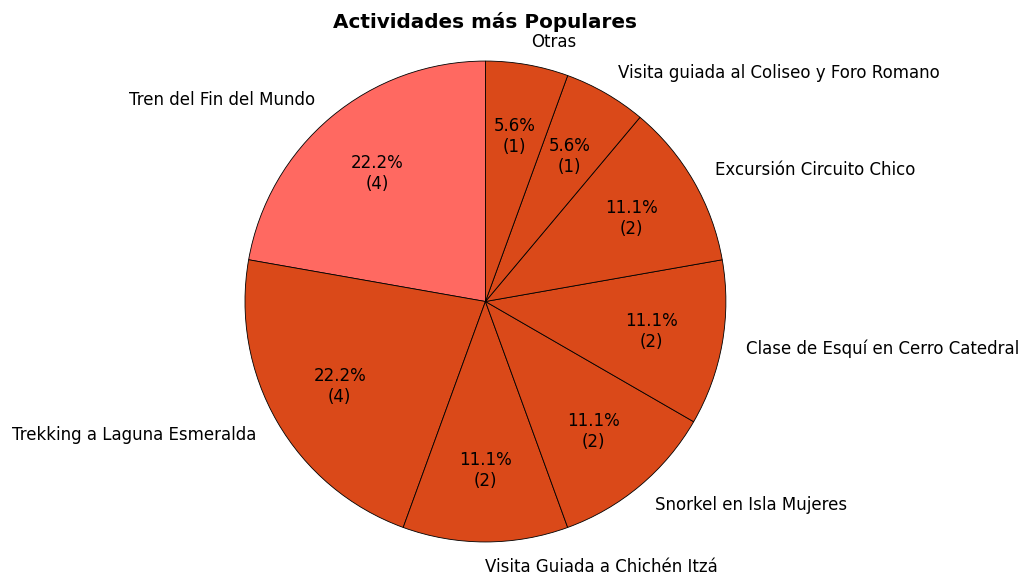

In [1131]:
def calcular_actividad_mas_popular():
    """Calcula la popularidad de actividades contando las reservas a partir del array 'actividades_ids' en la colección 'reservas' (MongoDB)."""
    
    pipeline = [
        # 1. Desplegar el array: crea un documento por cada actividad_id
        {"$unwind": "$actividades_ids"}, 
        # 2. Agrupar por la actividad (ahora expuesta) y contar
        {"$group": {"_id": "$actividades_ids", "cantidad": {"$sum": 1}}},
        # 3. Ordenar
        {"$sort": {"cantidad": -1}}
    ]
    
    agg = list(db.reservas.aggregate(pipeline)) 
    
    if not agg:
        return pd.DataFrame()
    actividades_map = {
        a["actividad_id"]: a["nombre"] 
        for a in db.actividades.find({}, {"_id":0,"actividad_id":1,"nombre":1})
    }
    
    df = pd.DataFrame([{
        "actividad_id": a["_id"],
        "cantidad": a["cantidad"],
        "nombre": actividades_map.get(a["_id"], f"act_{a['_id']}")
    } for a in agg])
    
    return df[['actividad_id', 'nombre', 'cantidad']]

df_actividades_pop = calcular_actividad_mas_popular()

# ---------- Gráfico: torta
if df_actividades_pop.empty:
    print("⚠️ No hay datos para calcular popularidad de actividades.")
else:
    valores = df_actividades_pop["cantidad"].astype(int)
    etiquetas = df_actividades_pop["nombre"]

    top_k = 7 
    valores_top = valores[:top_k]
    etiquetas_top = etiquetas[:top_k]
    
    indice_mas_popular_original = 0
    
    if len(valores) > top_k:
        restantes_sum = valores[top_k:].sum()
        if restantes_sum > 0:
            etiquetas = etiquetas_top.tolist() + ["Otras"]
            valores = valores_top.tolist() + [restantes_sum]
            indice_a_destacar = 0
        else: 
            etiquetas, valores = etiquetas_top, valores_top
            indice_a_destacar = 0
    else:
        etiquetas, valores = etiquetas_top, valores_top
        indice_a_destacar = 0 

       
    # Color base pastel: Gris Azulado Pastel
    color_base = "#DA4919" 
    # Color de destaque pastel: Rojo Pastel
    color_destaque = '#FF6961' 
    
    # Inicializar todos los colores con el color base
    colores_personalizados = [color_base] * len(valores)
    
    # Destacar la sección más popular
    colores_personalizados[indice_a_destacar] = color_destaque
    
    actividad_mas_popular = df_actividades_pop.loc[0, "nombre"]
    cantidad_reservas = df_actividades_pop.loc[0, "cantidad"]

    print(f"✅ La actividad más popular es **{actividad_mas_popular}**. Cantidad de Reservas = **{cantidad_reservas:,}**.")
    
    # --- 3. Gráfico de Torta ---
    plt.figure(figsize=(7,5), dpi=120)
    
    plt.pie(
        valores,
        labels=etiquetas,
        # Formato: Muestra % y el valor absoluto
        autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100*sum(valores))):,})",
        startangle=90,
        colors=colores_personalizados, # Usamos la nueva lista de colores
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
        pctdistance=0.7 
    )
    
    plt.title("Actividades más Populares", fontsize=12, fontweight='bold')
    plt.axis("equal") 
    plt.tight_layout()
    plt.show()

# PARTE D: Realizar modificación en los datos

    - Incrementar el precio de las actividades de Tucuman en 5% 
    - Agregar al hotel id=1 el servicio de SPA 
    - Eliminar el destino que desee 
    - Eliminar un usuario que desee 
    - Eliminar las relaciones AMIGO_DE para un usuario que quiera. 

## Funciones para modificaciones

In [1132]:
def eliminar_usuario(nombre: str):
    """Eliminar un usuario de MongoDB y sus nodos/relaciones en Neo4j (Integrado)."""
    
    print(f"\n--- Eliminando Usuario {nombre} ---")
    
    # 1. Eliminar de Neo4j (Usuario y todas sus relaciones)
    try:
        q_neo4j = "MATCH (u:Usuario {nombre:$nombre}) DETACH DELETE u"
        with neo4j_driver.session() as s:
            s.run(q_neo4j, nombre=nombre)
        print(f"✅ Usuario {nombre} eliminado de Neo4j (Nodos y Relaciones).")
    except Exception as e:
        print(f"❌ Error al eliminar usuario en Neo4j: {e}")
    
    # 2. Eliminar de MongoDB (Colección Usuarios)
    try:
        db.usuarios.delete_one({"nombre": nombre})
        print(f"✅ Usuario {nombre} eliminado de MongoDB (Colección Usuarios).")
    except Exception as e:
        print(f"❌ Error al eliminar usuario en MongoDB: {e}")

def eliminar_relaciones_amigo_de(nombre_usuario: str):
    """Eliminar todas las relaciones AMIGO_DE para un usuario específico (Neo4j)."""
    
    try:
        q_neo4j = """
        MATCH (u:Usuario {nombre: $nombre_usuario})-[r:AMIGO_DE]-() 
        DELETE r
        """
        with neo4j_driver.session() as s:
            s.run(q_neo4j, nombre_usuario=nombre_usuario)
        print(f"✅ Todas las relaciones AMIGO_DE de '{nombre_usuario}' han sido eliminadas (Neo4j).")
    except Exception as e:
        print(f"❌ Error al eliminar relaciones AMIGO_DE en Neo4j: {e}")
        

def eliminar_destino(destino_id: int):
    """Eliminar un destino de MongoDB y sus nodos/relaciones en Neo4j (Integrado)."""
    
    print(f"\n--- Eliminando Destino ID {destino_id} ---")
    
    # 1. Eliminar de Neo4j (Destino y sus relaciones salientes/entrantes)
    try:
        q_neo4j = "MATCH (d:Destino {id:$destino_id}) DETACH DELETE d"
        with neo4j_driver.session() as s:
            s.run(q_neo4j, destino_id=destino_id)
        print(f"✅ Destino ID {destino_id} eliminado de Neo4j (Nodos y Relaciones).")
    except Exception as e:
        print(f"❌ Error al eliminar destino en Neo4j: {e}")

    # 2. Eliminar de MongoDB (Colecciones Hoteles y Destinos)
    try:
        db.hoteles.delete_many({"destino_id": destino_id})
        db.destinos.delete_one({"destino_id": destino_id})
        
        print(f"✅ Destino ID {destino_id} eliminado de MongoDB (Colección Destinos).")
        print(f"✅ Hoteles asociados al destino ID {destino_id} eliminados de MongoDB.")
    except Exception as e:
        print(f"❌ Error al eliminar destino en MongoDB: {e}")

def agregar_servicio_hotel(hotel_id: int, servicio: str):
    """Agregar un servicio a un hotel (MongoDB). Usa $addToSet para evitar duplicados."""
    try:
        res = db.hoteles.update_one(
            {"hotel_id": hotel_id}, 
            {"$addToSet": {"servicios": servicio}}
        )
        print(f"✅ Servicio '{servicio}' agregado al hotel {hotel_id}. Modificados: {res.modified_count} (MongoDB)")
    except Exception as e:
        print(f"❌ Error al agregar servicio en MongoDB: {e}")

def modificar_precio_actividades(ciudad: str, pct: float):
    """Incrementar precio de actividades en una ciudad por un porcentaje (MongoDB)."""
    try:
        res = db.actividades.update_many(
            {"ciudad": ciudad}, 
            {"$mul": {"precio": 1 + pct}}
        )
        print(f"✅ Incrementadas {res.modified_count} actividades en {ciudad} en un {pct*100:.1f}%. (MongoDB)")
    except Exception as e:
        print(f"❌ Error al modificar precios en MongoDB: {e}")

## Pruebas

In [1133]:
# Ejecución de Modificaciones
print("\n--- Modificaciones ---\n")

# a. Incrementar el precio de las actividades de Tucuman en 5%
modificar_precio_actividades("Tucuman", 0.05) 

# b. Agregar al hotel id=1 el servicio de SPA
agregar_servicio_hotel(hotel_id=1, servicio="SPA")

# c. Eliminar el destino que desee (Ejemplo: ID 5)
eliminar_destino(destino_id=5)

# d. Eliminar un usuario que desee (Ejemplo: Lucía Godoy"")
eliminar_usuario("Lucía Godoy")

# e. Eliminar las relaciones AMIGO_DE para un usuario que quiera (Ejemplo: "María García")
eliminar_relaciones_amigo_de("María García")


--- Modificaciones ---

✅ Incrementadas 0 actividades en Tucuman en un 5.0%. (MongoDB)
✅ Servicio 'SPA' agregado al hotel 1. Modificados: 1 (MongoDB)

--- Eliminando Destino ID 5 ---
✅ Destino ID 5 eliminado de Neo4j (Nodos y Relaciones).
✅ Destino ID 5 eliminado de MongoDB (Colección Destinos).
✅ Hoteles asociados al destino ID 5 eliminados de MongoDB.

--- Eliminando Usuario Lucía Godoy ---
✅ Usuario Lucía Godoy eliminado de Neo4j (Nodos y Relaciones).
✅ Usuario Lucía Godoy eliminado de MongoDB (Colección Usuarios).
✅ Todas las relaciones AMIGO_DE de 'María García' han sido eliminadas (Neo4j).


## PARTE F. Cierre de Conexiones
    Se cierran las conexiones a las bases de datos.

In [1134]:
if neo4j_driver:
    neo4j_driver.close()
if mongo_client:
    mongo_client.close()
if redis_client:
    redis_client.close()
print("🔒 Conexiones cerradas correctamente.")

🔒 Conexiones cerradas correctamente.
